In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import disk_in_orbit as dio
from batman._quadratic_ld import _quadratic_ld as qld

## set up some functions

In [2]:
def inv_var_weight_avg(x, ex):
    # compute inverse variance weighted average and error
    w = 1./(ex**2) # weights
    x_wav = np.nansum(w * x, axis=0) / np.nansum(w, axis=0)
    σ_wav = 1./np.sqrt(np.nansum(w, axis=0))
    return x_wav, σ_wav

In [3]:
def make_flux(mags, mag_errors, baseline_mag):
    fluxes = 10**(0.4*(baseline_mag- mags))
    flux_errors = fluxes * (10**((2*mag_errors)/5) - 1)
    return fluxes, flux_errors

## load and format data

In [4]:
# Load I data
I = np.genfromtxt('data/OGLE.I.dat', dtype=['f8','f4','f4'], names=['tobs','mag','emag'])
imags = I["mag"]
eimags = I["emag"]
imjdobs = I["tobs"]+50000.
# estimated baseline mag
t0_est = int(imjdobs[np.argmax(imags)])
m0_i_est, em0_i_est = inv_var_weight_avg(imags[np.abs(imjdobs-t0_est)>365],
                                         eimags[np.abs(imjdobs-t0_est)>365])
# relative I band flux
iflux, iflux_error = make_flux(imags, eimags, m0_i_est)

In [5]:
# mjdobs, fluxes, flux errors to use for fitting
fit_mjdobs = imjdobs[np.abs(imjdobs-t0_est)<200]
fit_fluxes = iflux[np.abs(imjdobs-t0_est)<200]
fit_flux_errors = iflux_error[np.abs(imjdobs-t0_est)<200]

## quick test of circular occulter vs. batman

In [6]:
def bm_dist(t0, t, dx, uy):
    dt = t-t0
    return np.hypot(dx,uy*dt)

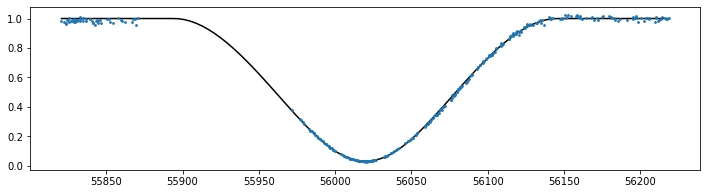

In [7]:
t_model = np.linspace(np.min(fit_mjdobs), np.max(fit_mjdobs), 100)
# from a previous run...
t0, b, v, r, u = [5.60199853e+04, 3.38899317e-01, 1.72803790e-02, 1.19167616e+00, 9.50403804e-01]
# 
b_model = bm_dist(t0, t_model, b, v)
f_model = qld(b_model, r, u, 0., 1)
plt.figure(figsize=(12,3))
plt.plot(t_model, f_model, c='k')
plt.scatter(fit_mjdobs, fit_fluxes, s=3, zorder=10)
plt.show()

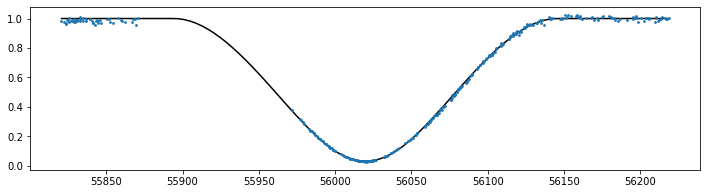

In [8]:
I,xp,yp = dio.get_I(step=0.01, mu=u)
f = dio.get_model_lc_disk(I,xp,yp,t_model,t0,v,b,r,r,0.0,0.0)
plt.figure(figsize=(12,3))
plt.plot(t_model, f, c='k')
plt.scatter(fit_mjdobs, fit_fluxes, s=3, zorder=10)
plt.show()

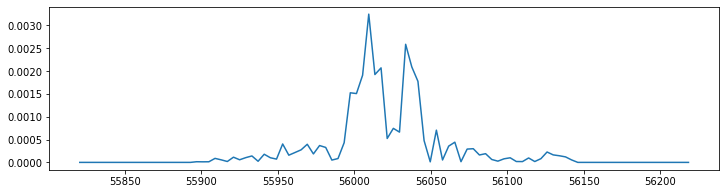

In [9]:
plt.figure(figsize=(12,3))
plt.plot(t_model, np.abs(f_model-f)/f_model)
plt.show()

In [10]:
getf = lambda gs : dio.get_model_lc_disk(*dio.get_I(step=gs, mu=u),t_model,t0,v,b,r,r,0.0,0.0)
gsteps = np.logspace(np.log10(0.002),np.log10(0.5),40)
max_err = [np.max(np.abs(f_model-getf(gs))/f_model) for gs in gsteps]

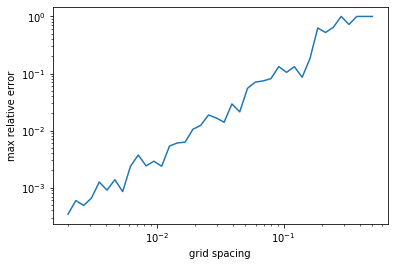

In [11]:
plt.plot(gsteps,max_err)
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.xlabel("grid spacing")
plt.ylabel("max relative error")
plt.show()

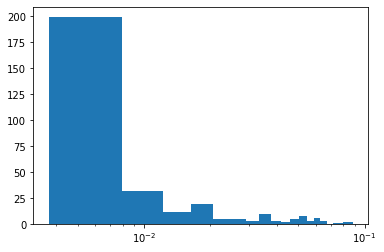

0.003690958
0.003115264797507788


In [12]:
plt.hist(fit_flux_errors/fit_fluxes, bins=20)
plt.gca().set_xscale("log")
plt.show()
print(np.min(fit_flux_errors/fit_fluxes))
print(float(np.count_nonzero(fit_flux_errors/fit_fluxes<0.004))/fit_fluxes.size)

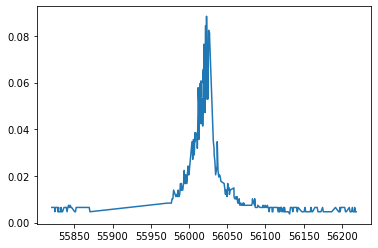

In [13]:
plt.plot(fit_mjdobs, fit_flux_errors/fit_fluxes)

## ratio of model error to data error

In [14]:
# from a previous run...
t0, b, v, r, u = [5.60199853e+04, 3.38899317e-01, 1.72803790e-02, 1.19167616e+00, 9.50403804e-01]
# 
b_fit = bm_dist(t0, fit_mjdobs, b, v)
f_fit = qld(b_fit, r, u, 0., 1)

In [15]:
getf = lambda gs : dio.get_model_lc_disk(*dio.get_I(step=gs, mu=u),fit_mjdobs,t0,v,b,r,r,0.0,0.0)
gsteps = np.logspace(np.log10(0.002),np.log10(0.5),30)
def get_rel_err(gs):
    print(gs)
    err_ratio = np.abs(f_fit-getf(gs)) / fit_flux_errors
    return np.max(err_ratio)
max_err = [get_rel_err(gs) for gs in gsteps]

0.0020000000000000005
0.0024194551849188385
0.0029268816959153246
0.003540729547413191
0.004283318230942088
0.005181648251255109
0.006268382863962409
0.007583035710635123
0.009173407533760426
0.011097324210465097
0.013424739299867572
0.016240277552624152
0.019646311864608763
0.023766685552680078
0.02875121529438374
0.034781138458357286
0.04207570289022627
0.05090013875843124
0.06157530231608742
0.07448934222580136
0.09011181263470441
0.10901074615073524
0.1318733074931339
0.1595307787833296
0.19298878494073346
0.2334638581780221
0.2824276710799859
0.3416605465795124
0.4133161904520027
0.5


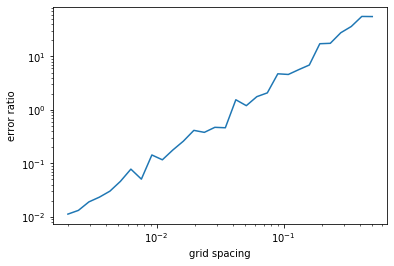

In [16]:
plt.plot(gsteps,max_err)
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.xlabel("grid spacing")
plt.ylabel("error ratio")
plt.show()

0.018201398357205235
0.1176737818538875


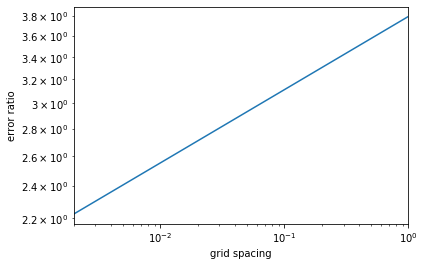

In [29]:
_p = np.polyfit(np.log10(max_err), np.log10(gsteps), deg=1)
_p2 = np.polyfit(np.log10(gsteps), np.log10(max_err), deg=1)
print(10**np.polyval(_p, np.log10(0.3)))
print(10**np.polyval(_p2, np.log10(0.01)))
__x = [0.002,1E0]
plt.plot(__x, np.polyval(_p2, __x))
plt.xlabel("grid spacing")
plt.ylabel("error ratio")
plt.xlim(*__x)
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.show()